In [1]:
%store -r df

In [2]:
%store -r input_w2v

In [63]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout
from keras.layers import LSTM
from keras.datasets import imdb
from keras.utils import pad_sequences
import numpy as np
import tensorflow as tf

In [64]:
# we first define a function that will be a scheduler and will permit to our learning rate to decrease over epochs
def scheduler(epoch, lr):
    if epoch < 6:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [65]:
# we now implement our optimizer, chosen in the gridsearch part
from keras.optimizers import Adam

initial_lr = 0.001  # the default starting learning rate for Adam
adam_optimizer = Adam()

In [66]:
from keras.callbacks import LearningRateScheduler, EarlyStopping

# we also tried an higher value for the early stopping patience and a lower number of epochs to make sure the task wasn't too computationally difficult
total_epochs = 20  
patience = 10  

# the learning rate scheduler takes as input a function that returns the desired learning rate for a given epoch
lr_scheduler = LearningRateScheduler(lambda epoch: scheduler(epoch, initial_lr)) 
early_stopping = EarlyStopping(monitor='val_accuracy', patience=patience, verbose=1, restore_best_weights=True)

In [67]:
max_len = max(len(arg) for arg in input_w2v)  # the max len of the embedding matrix
max_len

128

In [68]:
X = pad_sequences(input_w2v, maxlen=max_len)
y = df.labels

In [69]:
emb_len = len(X[0][0]) # the length of the embedding features

In [70]:
# performing the split between validation and training set
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 54)

In [71]:
# tranforming the y values of the training set in numpy arrays
y_train = y_train.to_numpy()
y_train = np.array(y_train.tolist())

In [72]:
# tranforming the y values of the validation set in numpy arrays
y_val = y_val.to_numpy()
y_val = np.array(y_val.tolist())

In [73]:
# implement the best model to plot the loss and the accuracy over epochs
best_params = {'batch': 64, 'dropout': 0.3, 'optimizer': 'adam'}

model = Sequential()
model.add(LSTM(100, dropout=best_params["dropout"], return_sequences=True, recurrent_dropout=best_params["dropout"], input_shape = (max_len, emb_len), activation="relu"))
model.add(Dropout(best_params["dropout"]))
model.add(LSTM(50, dropout=best_params["dropout"], recurrent_dropout=best_params["dropout"], input_shape = (257, 1), activation="relu"))
model.add(Dropout(best_params["dropout"]))
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=best_params["optimizer"], metrics=['accuracy'])
# Display the model summary
model.summary()

history = model.fit(X_train, y_train,
        epochs=total_epochs,
        validation_data=(X_val, y_val),
        batch_size=best_params["batch"],
        verbose=1,
        callbacks=[early_stopping, lr_scheduler])

validation_accuracy = history.history['val_accuracy']
validation_accuracy

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 128, 100)          100400    
                                                                 
 dropout_10 (Dropout)        (None, 128, 100)          0         
                                                                 
 lstm_11 (LSTM)              (None, 50)                30200     
                                                                 
 dropout_11 (Dropout)        (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 4)                 204       
                                                                 
Total params: 130804 (510.95 KB)
Trainable params: 130804 (510.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
35/

[0.4133574068546295,
 0.47111913561820984,
 0.4747292399406433,
 0.48736461997032166,
 0.49277979135513306,
 0.4855595529079437,
 0.5180505514144897,
 0.5270758271217346,
 0.4855595529079437,
 0.5144404172897339,
 0.5144404172897339,
 0.5324909687042236,
 0.5324909687042236,
 0.5306859016418457,
 0.5324909687042236,
 0.5090252757072449,
 0.512635350227356,
 0.512635350227356,
 0.5162454843521118,
 0.5108303427696228]

In [74]:
import matplotlib.pyplot as plt

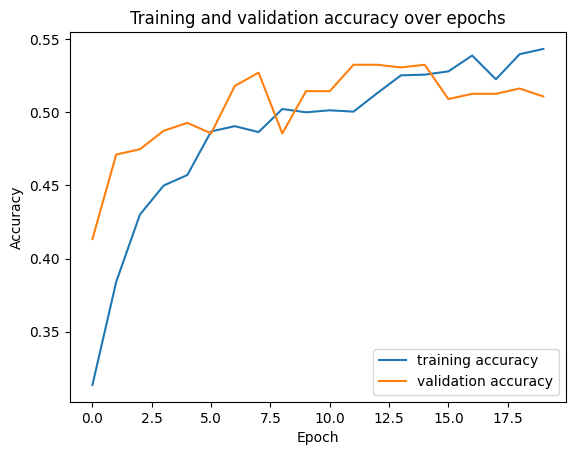

In [75]:
#plot training accuracy and validation accuracy
plt.plot(history.history["accuracy"], label = "training accuracy")
plt.plot(history.history["val_accuracy"], label = "validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and validation accuracy over epochs")
plt.legend()
plt.show()

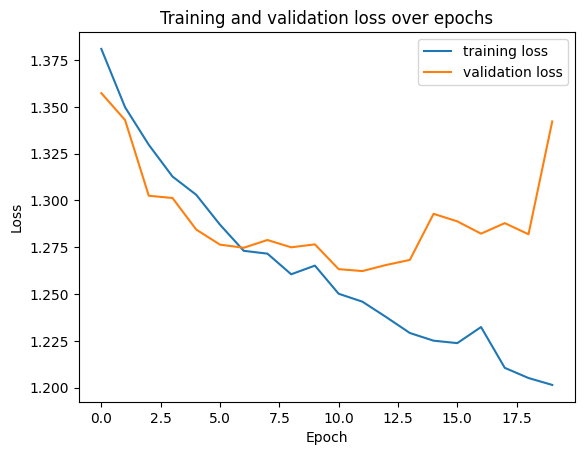

In [76]:
#plot training loss and validation loss
plt.plot(history.history["loss"], label = "training loss")
plt.plot(history.history["val_loss"], label = "validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and validation loss over epochs")
plt.legend()
plt.show()

From the regularization it seems clear that the best model is obtained at the 12th epoch

To do:
- save each checkpoint and choose the best model to evaluate on the test set